##### Copyright 2018 The TensorFlow Authors.

# Train your first neural network: basic classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This guide trains a neural network model to classify images of clothing, like sneakers and shirts. It's okay if you don't understand all the details, this is a fast-paced overview of a complete TensorFlow program with the details explained as we go.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

In [96]:
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_datasets as tdfs
tf.logging.set_verbosity(tf.logging.ERROR)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm


#tf.enable_eager_execution()  

print(tf.__version__)

1.14.1-dev20190307


## Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc) in an identical format to the articles of clothing we'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code. 

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow, just import and load the data:

In [97]:

dataset, metadata = tdfs.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
#train_dataset, test_dataset = dataset['train'], dataset['test']
#fashion_mnist = keras.datasets.fashion_mnist
#(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))


Number of training examples: 60000
Number of test examples:     10000


In [95]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(len(train_images[29]))

28


## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [98]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)




In [ ]:
print("before train_dataset", train_dataset)

mnist_example, = train_dataset.take(1)
image = mnist_example[0]
label = mnist_example[1]
#print("mnist_example", tf.slice(image, [1, 0, 0], [1, 1]))
print("image", image)
print("label", label)

#image, label = mnist_example["image"], mnist_example["label"]

#train_dataset_original = mnist_example[0]
#print("train_dataset_original", len(train_dataset_original))
test_dataset_original = test_dataset

Likewise, there are 60,000 labels in the training set:

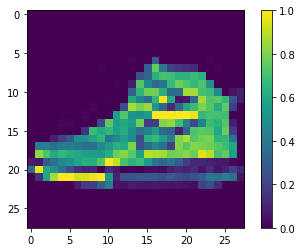

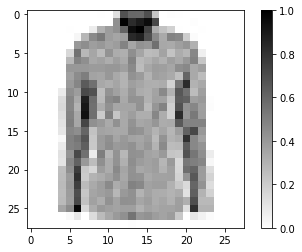

In [9]:
# Take a single image, and remove the color dimension by reshaping
for image, label in train_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.grid(False)
plt.show()

for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()



Each label is an integer between 0 and 9:

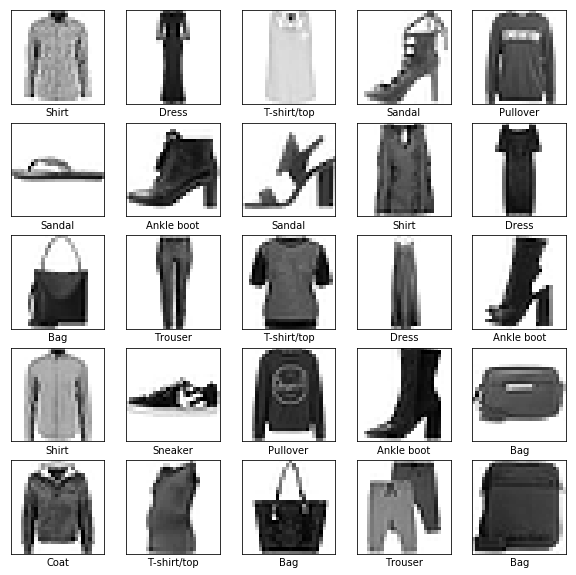

In [8]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

There are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels:

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

In [99]:

BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)




Display the first 25 images from the *training set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

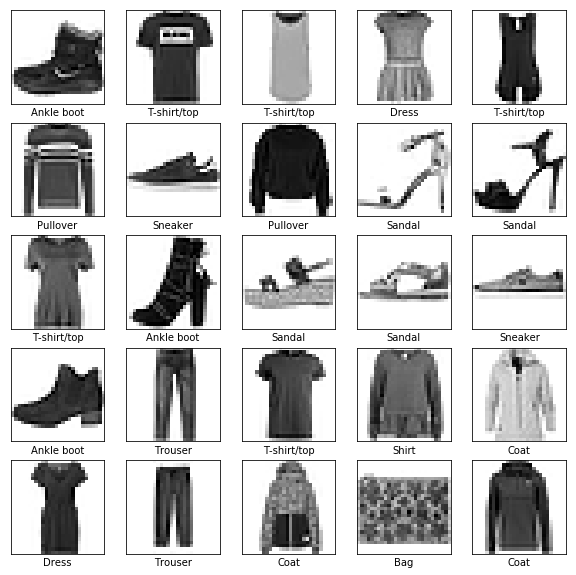

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Setup the layers

The basic building block of a neural network is the *layer*. Layers extract representations from the data fed into them. And, hopefully, these representations are more meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have parameters that are learned during training.

In [100]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

modelCNN = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a 2d-array (of 28 by 28 pixels), to a 1d-array of 28 * 28 = 784 pixels. Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely-connected, or fully-connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer is a 10-node *softmax* layer—this returns an array of 10 probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the 10 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:

* *Loss function* —This measures how accurate the model is during training. We want to minimize this function to "steer" the model in the right direction.
* *Optimizer* —This is how the model is updated based on the data it sees and its loss function.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [101]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
modelCNN.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


## Train the model



To start training,  call the `model.fit` method—the model is "fit" to the training data:

In [102]:
#model.fit(image, label, epochs=5)
modelCNN.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))


Epoch 1/5
1875/1875 [==============================] - 40s 22ms/step - loss: 0.3983 - acc: 0.8566
Epoch 2/5
1875/1875 [==============================] - 38s 20ms/step - loss: 0.2593 - acc: 0.9059
Epoch 3/5
1875/1875 [==============================] - 38s 20ms/step - loss: 0.2099 - acc: 0.9230
Epoch 4/5
1875/1875 [==============================] - 38s 20ms/step - loss: 0.1846 - acc: 0.9316
Epoch 5/5
1875/1875 [==============================] - 38s 20ms/step - loss: 0.1562 - acc: 0.9430


As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.88 (or 88%) on the training data.

## Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [103]:
test_loss, test_accuracy = modelCNN.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 2s 8ms/step - loss: 0.2563 - acc: 0.9153
Accuracy on test dataset: 0.9153


It turns out, the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy is an example of *overfitting*. Overfitting is when a machine learning model performs worse on new data than on their training data. 

## Make predictions

With the model trained, we can use it to make predictions about some images.

In [24]:
predictions = model.predict(test_images)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [19]:
predictions[0]

array([8.1982907e-06, 1.1555259e-07, 5.8913952e-06, 1.3256813e-07,
       3.1238665e-06, 4.6386715e-02, 6.0092138e-06, 2.2452874e-01,
       5.4276432e-05, 7.2900677e-01], dtype=float32)

A prediction is an array of 10 numbers. These describe the "confidence" of the model that the image corresponds to each of the 10 different articles of clothing. We can see which label has the highest confidence value:

In [21]:
np.argmax(predictions[0])

9

So the model is most confident that this image is an ankle boot, or `class_names[9]`. And we can check the test label to see this is correct:

In [23]:
test_labels[0]

9

We can graph this to look at the full set of 10 channels

In [25]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array. 

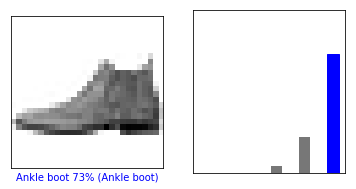

In [26]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

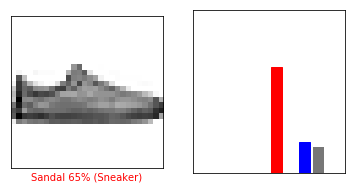

In [27]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident. 

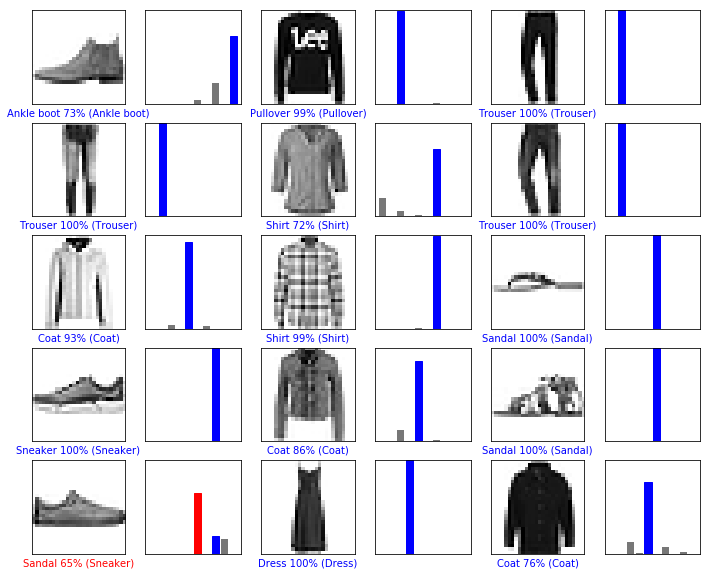

In [28]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()

Finally, use the trained model to make a prediction about a single image. 

In [29]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. So even though we're using a single image, we need to add it to a list:

In [30]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


Now predict the image:

In [31]:
predictions_single = model.predict(img)

print(predictions_single)

[[8.1982735e-06 1.1555268e-07 5.8913884e-06 1.3256799e-07 3.1238658e-06
  4.6386678e-02 6.0092129e-06 2.2452892e-01 5.4276323e-05 7.2900665e-01]]


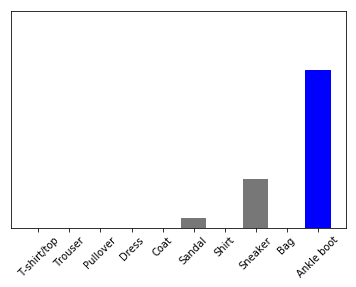

In [32]:
plot_value_array(0, predictions_single, test_labels)
plt.xticks(range(10), class_names, rotation=45)
plt.show()

`model.predict` returns a list of lists, one for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [33]:
prediction_result = np.argmax(predictions_single[0])
print(prediction_result)

9


And, as before, the model predicts a label of 9.

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)